In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/raw.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive')


In [3]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.4 MB/s eta 0:00:00


In [5]:
!pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.4 MB/s eta 0:00:00


In [41]:
!pip install transformers

In [46]:
!pip install imbalanced-learn

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from underthesea import word_tokenize

from deep_translator import GoogleTranslator
import time

import random

from imblearn.over_sampling import RandomOverSampler

Load training set

In [7]:
train_set = pd.read_csv("/content/drive/MyDrive/raw/train.csv")
dev_set = pd.read_csv("/content/drive/MyDrive/raw/dev.csv")
test_set = pd.read_csv("/content/drive/MyDrive/raw/test.csv")

In [8]:
train_set.head(10)

,free_text,label_id
0,Em được làm fan cứng luôn rồi nè ❤️ reaction q...,0
1,Đúng là bọn mắt híp lò xo thụt :))) bên việt n...,2
2,Đậu Văn Cường giờ giống thằng sida hơn à,0
3,CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯ...,2
4,Từ lý thuyết đến thực hành là cả 1 câu chuyện ...,0
5,Coronavirus is manmade,0
6,Đố chúng m nhận ra ai,0
7,Lúp lúp như chó .,1
8,🥰🥰🥰,0
9,"Thế mà mình nói mấy thằng bắc kì, bọn đó lại b...",2


In [9]:
dev_set.head(10)

,free_text,label_id
0,Coi cười xỉu,0
1,Chi ba vang ngoc dep va tre mai,0
2,"Chần vần một đống, không ai đoán trước được đừ...",0
3,Du học sinh Úc mà lại,0
4,Dm báo lá cải.. Nghĩ gì khi ở qn mà có hơn 30%...,0
5,Mai Đoàn mới nãy không thấy ai rep cmt vừa rep...,0
6,My su,0
7,Muốn có 1 cô em trong bộ tộc cùng hợp tác để r...,0
8,gays lên nn,0
9,@Ngoc Quynh Nhu Nguyen Nó góp ý thì có ngon và...,2


In [10]:
test_set.head(10)

,free_text,label_id
0,Đừng cố biện minh =)))) choi lon,0
1,Haizz. Nthe này thì dân khổ quá,1
2,the nay ma chi phat gay roi trat tu cong cong ...,0
3,Mua cho em hộp bcs mĩ sài cho oai :)),0
4,coin card :3,1
5,K có điểm dừng luôn hả trời ☹️☹️☹️,0
6,cái gì thế :)),0
7,Chi ba Chui hay qua,0
8,Lê Văn Quật xin vid ông,0
9,"Lý khùng thì có,kk",0


Check missing value

In [11]:
missing_values = train_set.isnull().sum()

print(missing_values)

missing_percentage = (missing_values / len(train_set)) * 100

missing_percentage


free_text    2
label_id     0
dtype: int64


,0
free_text,0.008317
label_id,0.000000


In [12]:
missing_values = dev_set.isnull().sum()

print(missing_values)

missing_percentage = (missing_values / len(dev_set)) * 100

missing_percentage


free_text    0
label_id     0
dtype: int64


,0
free_text,0.0
label_id,0.0


In [13]:
missing_values = test_set.isnull().sum()

print(missing_values)

missing_percentage = (missing_values / len(test_set)) * 100

missing_percentage


free_text    0
label_id     0
dtype: int64


,0
free_text,0.0
label_id,0.0


In [14]:
train_set = train_set.dropna()
train_set.isnull().sum()


,0
free_text,0
label_id,0


check duplicate values

In [15]:
duplicate_rows = train_set[train_set.duplicated()]
print("Number of duplicate rows:", len(duplicate_rows))
duplicate_rows


Number of duplicate rows: 1356


,free_text,label_id
225,reaction thầy ơi,0
442,đặt khô gà ở đâu v thầy ơi,0
466,Mệt quá thầy ạ 😞,0
696,xin ạ,0
790,Tại sao phải trả lời thầy,0
...,...,...
23986,Đình Quang ụa đâu có giải gì bên vn đau ta,0
23992,Thành Huy Hoàng Tiến,0
24008,Tự hào thầy Ba gold :)),0
24010,Lỡ tay thầy ơi :)),0


In [16]:
train_set = train_set.drop_duplicates()
len(train_set[train_set.duplicated()])


0

get class distribution

In [17]:
train_set['label_id'].value_counts()

,count
label_id,
0,18652
2,2495
1,1543


In [18]:
dev_set['label_id'].value_counts()

,count
label_id,
0,2190
2,270
1,212


In [19]:
test_set['label_id'].value_counts()

,count
label_id,
0,5548
2,688
1,444


EDA

Plot class distribution

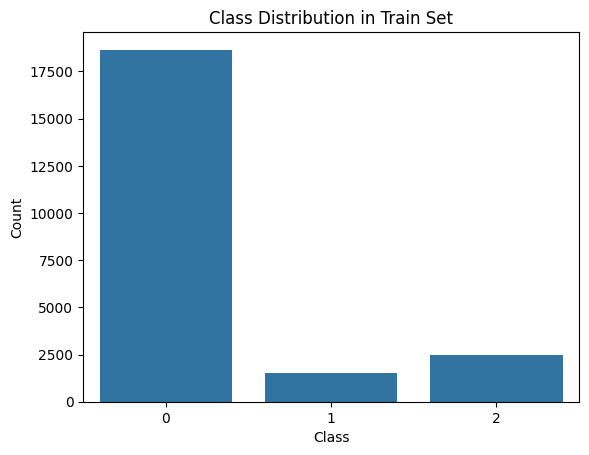

In [20]:
sns.countplot(x=train_set['label_id'])
plt.title("Class Distribution in Train Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

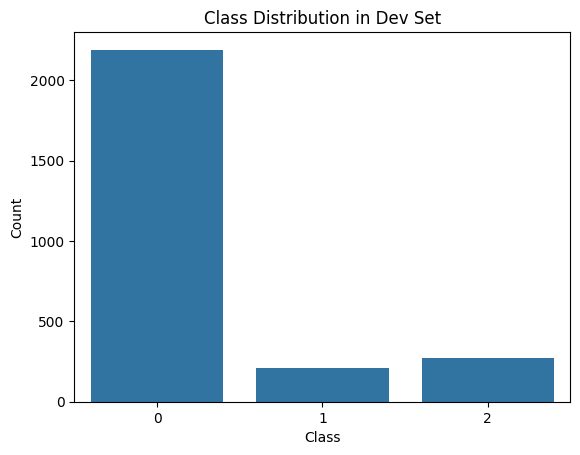

In [21]:
sns.countplot(x=dev_set['label_id'])
plt.title("Class Distribution in Dev Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

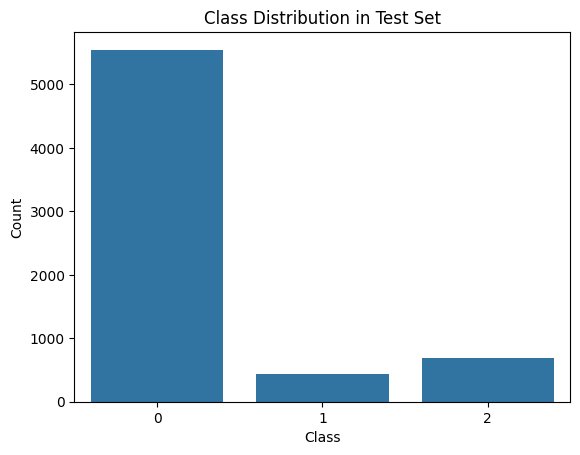

In [22]:
sns.countplot(x=test_set['label_id'])
plt.title("Class Distribution in Test Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

Plot text length distribution

In [23]:
train_set['text_length'] = train_set['free_text'].apply(lambda x: len(str(x).split()))
dev_set['text_length'] = dev_set['free_text'].apply(lambda x: len(str(x).split()))
test_set['text_length'] = test_set['free_text'].apply(lambda x: len(str(x).split()))

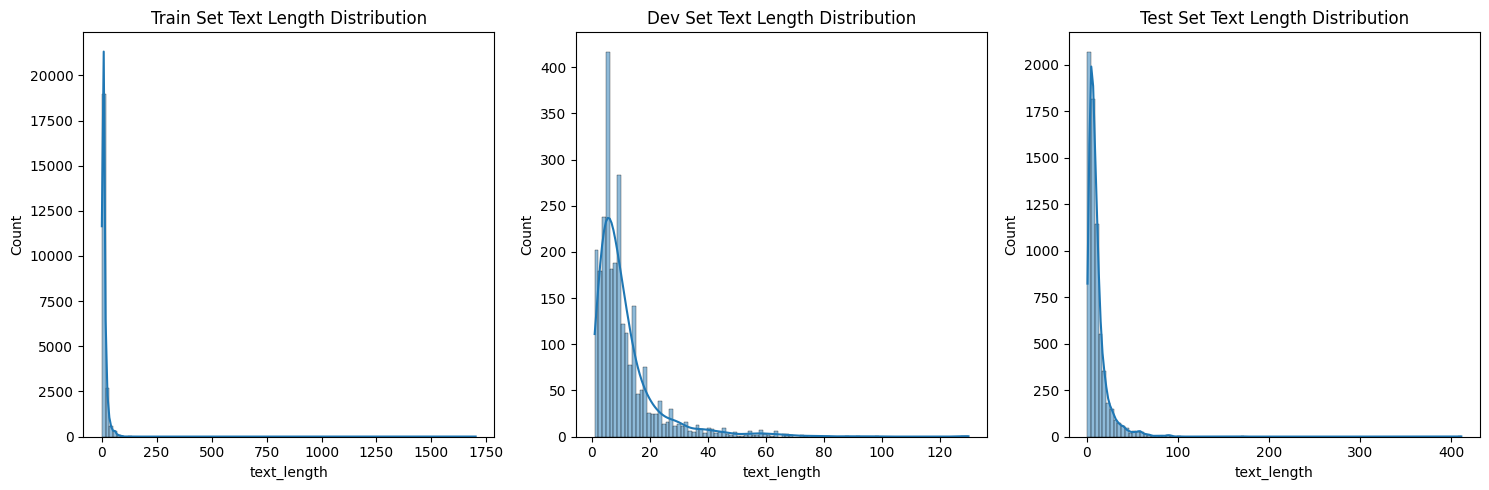

In [24]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(train_set['text_length'], bins=100, kde=True)
plt.title('Train Set Text Length Distribution')

plt.subplot(1, 3, 2)
sns.histplot(dev_set['text_length'], bins=100, kde=True)
plt.title('Dev Set Text Length Distribution')

plt.subplot(1, 3, 3)
sns.histplot(test_set['text_length'], bins=100, kde=True)
plt.title('Test Set Text Length Distribution')

plt.tight_layout()
plt.show()


In [25]:
print(train_set['text_length'].describe())

max_length = int(train_set['text_length'].quantile(0.95))
print(f"95th percentile text length: {max_length} words")


count    22690.000000
mean        11.775143
std         20.144481
min          1.000000
25%          5.000000
50%          8.000000
75%         14.000000
max       1701.000000
Name: text_length, dtype: float64
95th percentile text length: 33 words


In [26]:
print(dev_set['text_length'].describe())

max_length = int(dev_set['text_length'].quantile(0.95))
print(f"95th percentile text length: {max_length} words")


count    2672.000000
mean       11.509356
std        11.709861
min         1.000000
25%         5.000000
50%         8.000000
75%        14.000000
max       130.000000
Name: text_length, dtype: float64
95th percentile text length: 33 words


In [27]:
print(test_set['text_length'].describe())

max_length = int(test_set['text_length'].quantile(0.95))
print(f"95th percentile text length: {max_length} words")


count    6680.000000
mean       11.484581
std        12.442907
min         1.000000
25%         5.000000
50%         8.000000
75%        13.000000
max       411.000000
Name: text_length, dtype: float64
95th percentile text length: 33 words


In [28]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9À-Ỹà-ỹ\s]", "", text)
    text = word_tokenize(text, format="text")
    return text

In [29]:
train_set['cleaned_comment'] = train_set['free_text'].apply(clean_text)
dev_set['cleaned_comment'] = dev_set['free_text'].apply(clean_text)
test_set['cleaned_comment'] = test_set['free_text'].apply(clean_text)

In [30]:
train_set[['free_text', 'cleaned_comment']].head(15)

,free_text,cleaned_comment
0,Em được làm fan cứng luôn rồi nè ❤️ reaction q...,em được làm fan cứng luôn rồi nè reaction quá ...
1,Đúng là bọn mắt híp lò xo thụt :))) bên việt n...,đúng là bọn mắt híp lò_xo thụt bên việt_nam t ...
2,Đậu Văn Cường giờ giống thằng sida hơn à,đậu văn_cường giờ giống thằng sida hơn à
3,CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯ...,côn_đồ cục súc vô_nhân_tính đề_nghi vn nhà_nướ...
4,Từ lý thuyết đến thực hành là cả 1 câu chuyện ...,từ lý_thuyết đến thực_hành là cả 1 câu_chuyện dài
5,Coronavirus is manmade,coronavirus is manmade
6,Đố chúng m nhận ra ai,đố chúng m nhận ra ai
7,Lúp lúp như chó .,lúp lúp như chó
8,🥰🥰🥰,
9,"Thế mà mình nói mấy thằng bắc kì, bọn đó lại b...",thế mà mình nói mấy thằng bắc kì_bọn đó lại bâ...


In [31]:
dev_set[['free_text', 'cleaned_comment']].head(15)

,free_text,cleaned_comment
0,Coi cười xỉu,coi cười xỉu
1,Chi ba vang ngoc dep va tre mai,chi ba vang ngoc dep va tre mai
2,"Chần vần một đống, không ai đoán trước được đừ...",chần_vần một đống không ai đoán trước được đừn...
3,Du học sinh Úc mà lại,du_học_sinh úc mà_lại
4,Dm báo lá cải.. Nghĩ gì khi ở qn mà có hơn 30%...,dm báo lá cải_nghĩ gì khi ở qn mà có hơn 30 hộ...
5,Mai Đoàn mới nãy không thấy ai rep cmt vừa rep...,mai_đoàn mới nãy không thấy ai rep cmt vừa rep...
6,My su,my_su
7,Muốn có 1 cô em trong bộ tộc cùng hợp tác để r...,muốn có 1 cô em trong bộ_tộc cùng hợp_tác để r...
8,gays lên nn,gays lên nn
9,@Ngoc Quynh Nhu Nguyen Nó góp ý thì có ngon và...,ngoc quynh nhu_nguyen nó góp_ý thì có ngon vào...


In [32]:
test_set[['free_text', 'cleaned_comment']].head(15)

,free_text,cleaned_comment
0,Đừng cố biện minh =)))) choi lon,đừng cố biện_minh choi lon
1,Haizz. Nthe này thì dân khổ quá,haizz nthe này thì dân khổ quá
2,the nay ma chi phat gay roi trat tu cong cong ...,the nay ma chi phat gay_roi trat_tu cong_cong ...
3,Mua cho em hộp bcs mĩ sài cho oai :)),mua cho em hộp bcs mĩ_sài cho oai
4,coin card :3,coin card 3
5,K có điểm dừng luôn hả trời ☹️☹️☹️,k có điểm dừng luôn hả trời
6,cái gì thế :)),cái gì thế
7,Chi ba Chui hay qua,chi ba chui hay qua
8,Lê Văn Quật xin vid ông,lê văn_quật xin vid ông
9,"Lý khùng thì có,kk",lý khùng thì cókk


Back Translate

In [33]:
def back_translate(text, source_lang="vi", target_lang="en"):
    try:
        translated = GoogleTranslator(source=source_lang, target=target_lang).translate(text)
        back_translated = GoogleTranslator(source=target_lang, target=source_lang).translate(translated)
        return back_translated
    except:
        return text

In [34]:
df_minority = train_set[train_set['label_id'].isin([1, 2])].copy()
df_minority['cleaned_comment_aug'] = df_minority['cleaned_comment'].apply(lambda x: back_translate(x))

df_augmented = pd.concat([train_set, df_minority[['label_id', 'text_length', 'cleaned_comment_aug']].rename(columns={"cleaned_comment_aug": "cleaned_comment"})])

In [35]:
df_augmented['label_id'].value_counts()

,count
label_id,
0,18652
2,4990
1,3086


In [36]:
df_augmented.head()

,free_text,label_id,text_length,cleaned_comment
0,Em được làm fan cứng luôn rồi nè ❤️ reaction q...,0,22,em được làm fan cứng luôn rồi nè reaction quá ...
1,Đúng là bọn mắt híp lò xo thụt :))) bên việt n...,2,29,đúng là bọn mắt híp lò_xo thụt bên việt_nam t ...
2,Đậu Văn Cường giờ giống thằng sida hơn à,0,9,đậu văn_cường giờ giống thằng sida hơn à
3,CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯ...,2,15,côn_đồ cục súc vô_nhân_tính đề_nghi vn nhà_nướ...
4,Từ lý thuyết đến thực hành là cả 1 câu chuyện ...,0,13,từ lý_thuyết đến thực_hành là cả 1 câu_chuyện dài


In [37]:
df_augmented.tail()

,free_text,label_id,text_length,cleaned_comment
24013,NaN,2,31,Công việc của CS đã đạt đến cấp trên và sau đó...
24016,NaN,2,13,Corona đã mất ý tưởng của mình
24027,NaN,1,36,Tôi không thấy anh chàng bị giết vì hàng nghìn...
24029,NaN,1,4,Mất hình ảnh của VL
24030,NaN,2,51,"Nói tóm lại, lần này là lần này, một vị tướng ..."


Synonym Replacement

In [43]:
synonym_dict = {
    "dốt": ["ngu", "kém hiểu biết", "dở"],
    "điên": ["khùng", "mất trí", "ngớ ngẩn"],
    "xấu": ["tệ", "kém", "không tốt"],
    "cực đoan": ["quá khích", "không kiểm soát"],
    "phản động": ["chống đối", "bất mãn"]
}

def replace_synonym(text):
    words = word_tokenize(text, format="text").split()
    new_words = [
        random.choice(synonym_dict[word]) if word in synonym_dict else word for word in words
    ]
    return " ".join(new_words)

In [44]:
df_minority['cleaned_comment_aug'] = df_minority['cleaned_comment'].apply(replace_synonym)

df_augmented = pd.concat([df_augmented, df_minority[['label_id', 'text_length', 'cleaned_comment_aug']].rename(columns={"cleaned_comment_aug": "cleaned_comment"})])

In [45]:
df_augmented['label_id'].value_counts()

,count
label_id,
0,18652
2,7485
1,4629


Random OverSampling

In [48]:
X = df_augmented[['cleaned_comment']]
y = df_augmented['label_id']

ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [49]:
df_balanced = pd.DataFrame({"cleaned_comment": X_resampled['cleaned_comment'], "label_id": y_resampled})

In [50]:
df_balanced['label_id'].value_counts()

,count
label_id,
0,18652
2,18652
1,18652


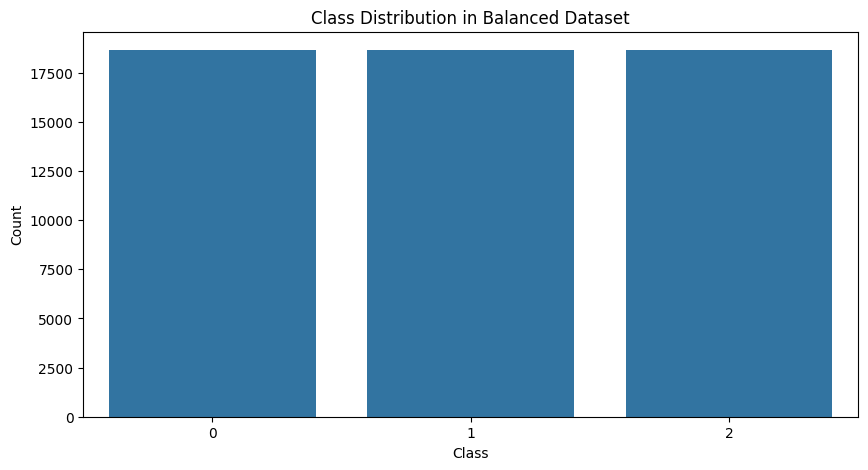

In [56]:
plt.figure(figsize=(10, 5))
sns.countplot(x=df_balanced['label_id'])
plt.title('Class Distribution in Balanced Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [52]:
df_balanced

,cleaned_comment,label_id
0,em được làm fan cứng luôn rồi nè reaction quá ...,0
1,đúng là bọn mắt híp lò_xo thụt bên việt_nam t ...,2
2,đậu văn_cường giờ giống thằng sida hơn à,0
3,côn_đồ cục súc vô_nhân_tính đề_nghi vn nhà_nướ...,2
4,từ lý_thuyết đến thực_hành là cả 1 câu_chuyện dài,0
...,...,...
55951,nhạ ngọng_học_sinh thi_trường lào là đỗ trường_ý,2
55952,con này thực_sự nó giống như con thú nhốt lâu ...,2
55953,"Những con chó sống như vậy, cả gia đình đều ổn...",2
55954,một thanh_niên rảnh_lol cho_hay dkm nhà mày nó...,2


In [53]:
train_set = df_balanced

In [57]:
train_set.to_csv("/content/drive/MyDrive/raw/processed_train.csv", index=False)
dev_set.to_csv("/content/drive/MyDrive/raw/processed_dev.csv", index=False)
test_set.to_csv("/content/drive/MyDrive/raw/processed_test.csv", index=False)

In [58]:
df = pd.read_csv("/content/drive/MyDrive/raw/processed_train.csv")
df.head()

,cleaned_comment,label_id
0,em được làm fan cứng luôn rồi nè reaction quá ...,0
1,đúng là bọn mắt híp lò_xo thụt bên việt_nam t ...,2
2,đậu văn_cường giờ giống thằng sida hơn à,0
3,côn_đồ cục súc vô_nhân_tính đề_nghi vn nhà_nướ...,2
4,từ lý_thuyết đến thực_hành là cả 1 câu_chuyện dài,0


In [59]:
df["cleaned_comment"].apply(type).value_counts()

,count
cleaned_comment,
<class 'str'>,55768
<class 'float'>,188


In [60]:
df2 = pd.read_csv("/content/drive/MyDrive/raw/processed_dev.csv")
df3 = pd.read_csv("/content/drive/MyDrive/raw/processed_test.csv")

In [61]:
df2["cleaned_comment"].apply(type).value_counts()

,count
cleaned_comment,
<class 'str'>,2653
<class 'float'>,19


In [62]:
df3["cleaned_comment"].apply(type).value_counts()

,count
cleaned_comment,
<class 'str'>,6614
<class 'float'>,66


In [63]:
df["cleaned_comment"] = df["cleaned_comment"].astype(str)
df2["cleaned_comment"] = df["cleaned_comment"].astype(str)
df3["cleaned_comment"] = df["cleaned_comment"].astype(str)

In [64]:
train_set.to_csv("/content/drive/MyDrive/raw/processed_train.csv", index=False)
dev_set.to_csv("/content/drive/MyDrive/raw/processed_dev.csv", index=False)
test_set.to_csv("/content/drive/MyDrive/raw/processed_test.csv", index=False)